## Learning-to-Rank via Orca with TF Ranking and TF Recommenders

based on 
- https://github.com/intel-analytics/BigDL/blob/main/python/orca/colab-notebook/quickstart/keras_lenet_mnist.ipynb
- https://github.com/tensorflow/recommenders/blob/main/docs/examples/listwise_ranking.ipynb



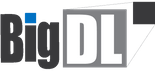
---

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install BigDL Orca**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray] -q

In [ ]:
!pip show bigdl-orca ray

Name: bigdl-orca
Version: 2.1.0b20220516
Summary: Seamlessly scale out TensorFlow and PyTorch for Big Data (using Spark & Ray)
Home-page: https://github.com/intel-analytics/analytics-zoo
Author: BigDL Authors
Author-email: bigdl-user-group@googlegroups.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: bigdl-tf, bigdl-dllib, pyzmq, filelock, packaging, bigdl-math
Required-by: 
---
Name: ray
Version: 1.9.2
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: jsonschema, redis, click, numpy, msgpack, grpcio, protobuf, attrs, pyyaml, filelock
Required-by: 


In [ ]:
!pip install numpy --upgrade # --ignore-installed

In [ ]:
!pip install tensorflow==2.7.0 tensorflow-recommenders tensorflow-ranking -q

In [ ]:
!pip show tensorflow tensorflow-recommenders tensorflow-ranking

Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: protobuf, keras, flatbuffers, numpy, typing-extensions, tensorflow-io-gcs-filesystem, grpcio, tensorboard, opt-einsum, wheel, gast, astunparse, absl-py, six, wrapt, keras-preprocessing, tensorflow-estimator, libclang, termcolor, h5py, google-pasta
Required-by: tensorflow-serving-api, tensorflow-recommenders, kapre
---
Name: tensorflow-recommenders
Version: 0.6.0
Summary: Tensorflow Recommenders, a TensorFlow library for recommender systems.
Home-page: https://github.com/tensorflow/recommenders
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorflow, absl-py
Required-by: 
---
Name: tensorflow-ranking
Version: 0.5.0

In [ ]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_ranking as tfr
print(tf.__version__)
print(tfrs.__version__)
print(tfr.__version__)

2.7.0
v0.6.0
0.5.0.dev


In [ ]:
import numpy as np
print(np.__version__)

1.21.6


## **Distributed TensorFlow 2 using Orca APIs**

In this guide we will describe how to scale out TensorFlow 2 programs using Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
import argparse

import bigdl.orca
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context** 

In [ ]:
# recommended to set it to True when running BigDL in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "k8s":  
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2) # run on K8s cluster
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
[main] WARN  org.apache.hadoop.util.NativeCodeLoader  - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-05-17 02:19:04,663 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-17 02:19:04,670 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-17 02:19:04,680 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-05-17 02:19:04,682 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-05-17 02:19:04 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-05-17 02:19:04 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 1



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

22-05-17 02:19:06 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 14
[Thread-4] WARN  org.apache.spark.SparkContext  - Using an existing SparkContext; some configuration may not take effect.
22-05-17 02:19:06 [Thread-4] INFO  Engine$:456 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
Successfully got a SparkContext
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity


This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 3: Define Dataset**


In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip && unzip ml-1m.zip
# ! cat ./ml-1m/README

--2022-05-17 02:19:07--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  32.0MB/s    in 0.2s    

2022-05-17 02:19:07 (32.0 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
def prepare_ml_sdfs(spark, data_path = './ml-1m/', verbose=False):
    data_path = os.path.join(data_path, "{}.dat")
    dataset = { 
        "ratings": ['userid', 'movieid',  'rating', 'timestamp'],
        "users": ["userid", "gender", "age", "occupation", "zip-code"],
        "movies": ["movieid", "title", "genres"]
    }
    # UserID::MovieID::Rating::Timestamp
    # UserID::Gender::Age::Occupation::Zip-code
    # MovieID::Title::Genres
    sdfs = dict()
    for data, cols in dataset.items():
        sdf_tmp = spark.read.csv(data_path.format(data), sep =':', header = False)
        tmp_cols = sdf_tmp.columns
        sdfs[data] = sdf_tmp.select(tmp_cols[::2]).toDF(*cols)
    return sdfs

spark = OrcaContext.get_spark_session()
sdfs = prepare_ml_sdfs(spark)

In [ ]:
def join_sdfs(sdfs, users=False):
    sdf_joined = sdfs["ratings"].join(sdfs["movies"], "movieid").dropna()
    if users:
        sdf_joined = sdf_joined.join(sdfs["users"], "userid").dropna()
    return sdf_joined

sdf_joined = join_sdfs(sdfs)
sdf_joined.show(4, False)

+-------+------+------+---------+--------------------------------------+----------------------------+
|movieid|userid|rating|timestamp|title                                 |genres                      |
+-------+------+------+---------+--------------------------------------+----------------------------+
|1193   |1     |5     |978300760|One Flew Over the Cuckoo's Nest (1975)|Drama                       |
|661    |1     |3     |978302109|James and the Giant Peach (1996)      |Animation|Children's|Musical|
|914    |1     |3     |978301968|My Fair Lady (1964)                   |Musical|Romance             |
|3408   |1     |4     |978300275|Erin Brockovich (2000)                |Drama                       |
+-------+------+------+---------+--------------------------------------+----------------------------+
only showing top 4 rows



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType

# cast
sdf_all = sdf_joined.withColumn("rating", F.col("rating").cast("int"))

In [ ]:
sdf_train, sdf_test = sdf_all.randomSplit([0.85, 0.15], seed=1)

In [ ]:
def userid_agg(sdf):
    cols = ["title", "rating"]
    f_cols = [F.col(col) for col in cols]
    sdf_agg = (
        sdf.groupBy("userid").agg(
            F.collect_list(F.struct(*cols)).alias("agg")
        )
    )
    def split_cols(data_list):
        ret = [[] for col in cols]
        for data in data_list:
            for n, d in enumerate(data):
                ret[n].append(d)
        return ret

    def split_cols_map(partition):
        for row in partition:
            splits = split_cols(row["agg"])
            yield [row["userid"], *splits]
    cols_out = [ col + "s" for col in cols]

    return sdf_agg.rdd.mapPartitions(split_cols_map).toDF(["userid", *cols_out])

sdf_list = userid_agg(sdf_train)
sdf_list.printSchema()

[Stage 7:>                                                          (0 + 1) / 1]

root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: long (containsNull = true)



In [ ]:
sdf_list.show(3, False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unique_movie_titles = [x["title"] for x in sdfs["movies"].select("title").distinct().collect()]
unique_userids = [x["userid"] for x in sdfs["users"].select("userid").distinct().collect()]

print(len(unique_movie_titles), len(unique_userids))
print(unique_movie_titles[0:2])
print(unique_userids[0:2])

[Stage 13:=============================================>        (170 + 1) / 200]

3865 6040
['Fair Game (1995)', 'If Lucy Fell (1996)']
['296', '467']


In [ ]:
unique_movie_titles[0:2]

['Fair Game (1995)', 'If Lucy Fell (1996)']

### Padding Dataframe
Orca does not support variable length columns now, so we make all list/array columns the same lengths. 

In [ ]:
MASK_TOKEN = "<MSK>"
MASK_RATING = -1

def list2pad_list(sdf_list):

    len_udf = F.udf(lambda x: len(x), IntegerType())
    sdf_list_len = sdf_list.withColumn("len", len_udf(F.col("ratings"))).sort(F.desc("len"))

    def pad_list(lst, length, size, padding=None):
        pad_size = size - length
        return [*lst, *[padding] * pad_size]
    
    max_len = sdf_list_len.agg({"len": "max"}).collect()[0]["max(len)"]
    min_len = sdf_list_len.agg({"len": "min"}).collect()[0]["min(len)"]
    print("max_min_len", (max_len, min_len))

    pad_str_udf = F.udf(lambda x, y: pad_list(x, y, max_len, MASK_TOKEN), ArrayType(StringType(), True))
    pad_int_udf = F.udf(lambda x, y: pad_list(x, y, max_len, MASK_RATING), ArrayType(IntegerType(), True))

    sdf_list_padded = (
        sdf_list_len
        .withColumn("titles", pad_str_udf(F.col("titles"), F.col("len")))
        .withColumn("ratings", pad_int_udf(F.col("ratings"), F.col("len")))
        .sort(F.desc("len"))
    )
    return sdf_list_padded, (max_len, min_len)


sdf_list_padded, max_min_len = list2pad_list(sdf_list)
sdf_list_padded.printSchema()

[Stage 24:===============================================>      (146 + 1) / 165]

max_min_len (1922, 10)
root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)



In [ ]:
pdf = sdf_list_padded.limit(10).toPandas()
pdf

,userid,titles,ratings,len
0,4169,"[GoldenEye (1995), City Hall (1996), Extreme M...","[4, 3, 3, 2, 4, 3, 3, 5, 4, 4, 4, 5, 3, 5, 4, ...",1922
1,1680,"[Extreme Measures (1996), Glimmer Man, The (19...","[4, 2, 4, 5, 3, 3, 4, 4, 4, 4, 4, 3, 1, 4, 4, ...",1459
2,4277,"[Toy Story (1995), GoldenEye (1995), City Hall...","[5, 4, 5, 4, 4, 3, 5, 4, 4, 4, 5, 5, 4, 5, 4, ...",1428
3,1941,"[GoldenEye (1995), Apple Dumpling Gang, The (1...","[4, 4, 4, 5, 5, 4, 4, 4, 5, 5, 4, 5, 4, 4, 3, ...",1258
4,1181,"[GoldenEye (1995), Glimmer Man, The (1996), Ch...","[4, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 5, 2, 2, ...",1218
5,889,"[Toy Story (1995), Bottle Rocket (1996), Old Y...","[4, 2, 5, 2, 2, 4, 3, 2, 4, 2, 2, 4, 4, 4, 3, ...",1213
6,3618,"[Toy Story (1995), GoldenEye (1995), City Hall...","[2, 3, 3, 3, 3, 2, 4, 5, 3, 2, 3, 4, 2, 3, 4, ...",1122
7,1150,"[Extreme Measures (1996), That Darn Cat! (1965...","[2, 2, 1, 2, 4, 2, 5, 3, 2, 2, 3, 1, 2, 4, 3, ...",1070
8,1015,"[City Hall (1996), Bottle Rocket (1996), 20,00...","[2, 3, 4, 3, 3, 5, 5, 5, 3, 2, 5, 4, 4, 5, 4, ...",1065
9,1980,"[Toy Story (1995), Chamber, The (1996), Apple ...","[4, 4, 3, 4, 3, 3, 3, 4, 4, 3, 4, 4, 1, 2, 4, ...",1041


### **3. Model**

In [ ]:
class Padded2RaggedModel(tfrs.Model):
    
    def __init__(self, unique_userids, unique_movie_titles, max_len, loss):
        super().__init__()
        embedding_dimension = 32
        self.max_len = max_len # for output padding
        self._loss = loss

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.Input(shape=(), dtype=tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_userids),
            tf.keras.layers.Embedding(len(unique_userids) + 2, embedding_dimension)
        ], name="user_emb")

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.Input(shape=(None,), dtype=tf.string, ragged=True),
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 2, embedding_dimension)
        ], name="movie_emb")

        # Compute predictions.
        self.score_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ], name="MLP")

        self._metrics = [
            tfr.keras.metrics.NDCGMetric(name="ndcg_metric", ragged=True),
            tf.keras.metrics.RootMeanSquaredError()
        ]
        
        self.task = tfrs.tasks.Ranking(
            loss=self._loss,
            metrics=self._metrics
        )
    
    @classmethod
    def _expand(cls, x):
        return tf.expand_dims(x, axis=-1)
    

    @classmethod
    def _repeat(cls, src, length, axis):
        return tf.repeat(
            tf.expand_dims(src, axis=axis),
            [length],
            axis=axis
        )
    
    def call(self, features, padding_output=True):

        userid = self._expand(features[0])
        titles = self._expand(features[1])
        lengths = features[-1]

        max_length = features[1].shape[1] # padded

        user_emb = self.user_embeddings(userid)
        user_emb_repeated = self._repeat(user_emb, max_length, -2)
        movie_emb = self.movie_embeddings(titles)

        concatenated_emb = tf.concat(
            [user_emb_repeated, movie_emb], axis=-1
        )

        scores = self.score_model(concatenated_emb)
        scores = tf.squeeze(scores, axis=-1)
        ragged_scores = tf.RaggedTensor.from_tensor(scores, lengths)
        # score
        if padding_output:
            ragged_shape = ragged_scores.shape
            return ragged_scores.to_tensor(np.inf, shape=(ragged_shape[0], self.max_len))
        return ragged_scores

    def compute_loss(self, inputs, training=False):

        features, labels = inputs
        lengths = features[-1]

        labels = tf.RaggedTensor.from_tensor(labels, lengths)
        #print(labels)
        labels = tf.cast(labels, dtype=tf.float32)
        scores = self.call(features, padding_output=False)
        return self.task(
            labels=labels,
            predictions=scores,
        )
    
    def compile_model(self, optimizer):
        self.compile(
            optimizer=optimizer,
            loss=self._loss,
            metrics=self._metrics,        
        )
        
demo_model = Padded2RaggedModel(
    unique_userids,
    unique_movie_titles,
    max_min_len[0],
    tfr.keras.losses.MeanSquaredLoss(tf.losses.Reduction.SUM, ragged=True),
)

demo_model.compile_model(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [ ]:
sample_rows = sdf_list_padded.take(11)

In [ ]:
# for local/driver test

def create_padded_batch(rows, batch_num, padded_cols):
    padded_batch = {
        col: np.array([rows[i][col] for i in range(0, min(batch_num, len(sample_rows)))])
        for col in padded_cols
    }
    return padded_batch


def padded2ragged(padded, padding):
    mask = tf.not_equal(padded, padding)
    ragged = tf.ragged.boolean_mask(padded, mask)
    return ragged


padded_batch = create_padded_batch(sample_rows, 10, padded_cols=sdf_list_padded.columns)
padded_batch

{'len': array([1922, 1459, 1428, 1258, 1218, 1213, 1122, 1070, 1065, 1041]),
 'ratings': array([[ 4,  3,  3, ...,  4,  4,  2],
        [ 4,  2,  4, ..., -1, -1, -1],
        [ 5,  4,  5, ..., -1, -1, -1],
        ...,
        [ 2,  2,  1, ..., -1, -1, -1],
        [ 2,  3,  4, ..., -1, -1, -1],
        [ 4,  4,  3, ..., -1, -1, -1]]),
 'titles': array([['GoldenEye (1995)', 'City Hall (1996)',
         'Extreme Measures (1996)', ..., 'Big Night (1996)',
         'Caught (1996)', '2 Days in the Valley (1996)'],
        ['Extreme Measures (1996)', 'Glimmer Man, The (1996)',
         'Apple Dumpling Gang, The (1975)', ..., '<MSK>', '<MSK>',
         '<MSK>'],
        ['Toy Story (1995)', 'GoldenEye (1995)', 'City Hall (1996)', ...,
         '<MSK>', '<MSK>', '<MSK>'],
        ...,
        ['Extreme Measures (1996)', 'That Darn Cat! (1965)',
         'Cool Runnings (1993)', ..., '<MSK>', '<MSK>', '<MSK>'],
        ['City Hall (1996)', 'Bottle Rocket (1996)',
         '20,000 Leagues Under t

In [ ]:
def dict2xy(dic, x_cols, y_col):
    return [dic[key] for key in x_cols], dic[y_col]

X_COLS = ["userid", "titles"] + ["len"] # features
Y_COL = "ratings" # label

xy = dict2xy(padded_batch, X_COLS, Y_COL)
xy[0]

[array(['4169', '1680', '4277', '1941', '1181', '889', '3618', '1150',
        '1015', '1980'], dtype='<U4'),
 array([['GoldenEye (1995)', 'City Hall (1996)',
         'Extreme Measures (1996)', ..., 'Big Night (1996)',
         'Caught (1996)', '2 Days in the Valley (1996)'],
        ['Extreme Measures (1996)', 'Glimmer Man, The (1996)',
         'Apple Dumpling Gang, The (1975)', ..., '<MSK>', '<MSK>',
         '<MSK>'],
        ['Toy Story (1995)', 'GoldenEye (1995)', 'City Hall (1996)', ...,
         '<MSK>', '<MSK>', '<MSK>'],
        ...,
        ['Extreme Measures (1996)', 'That Darn Cat! (1965)',
         'Cool Runnings (1993)', ..., '<MSK>', '<MSK>', '<MSK>'],
        ['City Hall (1996)', 'Bottle Rocket (1996)',
         '20,000 Leagues Under the Sea (1954)', ..., '<MSK>', '<MSK>',
         '<MSK>'],
        ['Toy Story (1995)', 'Chamber, The (1996)',
         'Apple Dumpling Gang, The (1975)', ..., '<MSK>', '<MSK>',
         '<MSK>']], dtype='<U79'),
 array([1922, 1459, 1428,

In [ ]:
# check call() / ()
score = demo_model.call(xy[0], False)
print(score.shape)
score = demo_model.call(xy[0], True)
print(score.shape)

(10, None)
(10, 1922)


In [ ]:
# check predct()
pred = demo_model.predict(xy[0]) # tfrs.Model convert data to tf
#pred.shape
print(pred.shape)

(10, 1922)


In [ ]:
# check compute_loss()
ret = demo_model.compute_loss(xy)
print(ret)

tf.Tensor(158040.64, shape=(), dtype=float32)


In [ ]:
demo_model.summary()

Model: "padded2_ragged_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_emb (Sequential)       (None, 32)                193344    
                                                                 
 movie_emb (Sequential)      (None, None, 32)          123744    
                                                                 
 MLP (Sequential)            (None, 1922, 1)           33153     
                                                                 
 ranking (Ranking)           multiple                  0         
                                                                 
Total params: 350,245
Trainable params: 350,241
Non-trainable params: 4
_________________________________________________________________


In [ ]:
# here for testing the training process, we use all the data instead of the sdf_train 
sdf_list_padded_train, max_min_len = list2pad_list(
    userid_agg(sdf_all)
)

sdf_list_padded_test, _ = list2pad_list(
    userid_agg(sdf_test)
)

sdf_list_padded_test.printSchema()
sdf_list_padded_test.show(3, False)

max_min_len (1922, 10)


max_min_len (312, 1)
root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)



[Stage 233:====================================================>(197 + 1) / 200]

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
num_partitions = 32
sdf_list_padded_train = sdf_list_padded_train.repartition(num_partitions).cache()
sdf_list_padded_test = sdf_list_padded_test.repartition(num_partitions).cache()
print(sdf_list_padded_train.rdd.getNumPartitions(), sdf_list_padded_test.rdd.getNumPartitions())

[Stage 303:===================================================> (194 + 1) / 200]

32 32


In [ ]:
ALL_COLS = X_COLS + [Y_COL]
test_data = dict2xy(
    create_padded_batch(sdf_list_padded_test.take(11), 1, sdf_list_padded_test.columns),
    X_COLS,
    Y_COL
)

model_config = {
    "learning_rate": 0.1,
    "userid_vocab": unique_userids,
    "movie_vocab": unique_movie_titles,
    "max_len": max_min_len[0],
    "test_data": test_data,
}

def create_model(config):
    # loss = tfr.keras.losses.MeanSquaredLoss(tf.losses.Reduction.SUM, ragged=True)
    # loss = tfr.keras.losses.ListMLELoss(tf.losses.Reduction.SUM, ragged=True)
    loss = tfr.keras.losses.ApproxNDCGLoss(reduction=tf.losses.Reduction.SUM, ragged=True)
    # loss = tf.keras.losses.MeanSquaredError(tf.keras.losses.Reduction.SUM)
    
    model = Padded2RaggedModel(
        config["userid_vocab"],
        config["movie_vocab"],
        config["max_len"],
        loss
    )

    model.compile_model(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
    )
    # dummy to build graph
    x, y = config['test_data']
    model(x)
    
    return model

In [ ]:
import tensorflow_datasets as tfds

_TEST_CREATE_FUNCTION = True

if _TEST_CREATE_FUNCTION:
    model = create_model(model_config)
    model.summary()
    x, y = model_config['test_data']
    ret = model.compute_loss((x, y))
    print(ret)
    ret = model.fit(x, y)
    ret = model.predict(x)
    print(ret.shape)

Model: "padded2_ragged_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_emb (Sequential)       (None, 32)                193344    
                                                                 
 movie_emb (Sequential)      (None, None, 32)          123744    
                                                                 
 MLP (Sequential)            (1, 312, 1)               33153     
                                                                 
 ranking_3 (Ranking)         multiple                  0 (unused)
                                                                 
Total params: 350,245
Trainable params: 350,241
Non-trainable params: 4
_________________________________________________________________
tf.Tensor(-0.73584837, shape=(), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/ranking_3/ApproxNDCGLoss/RaggedToTensor_2/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/ranking_3/ApproxNDCGLoss/RaggedToTensor_2/boolean_mask/GatherV2:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/ranking_3/ApproxNDCGLoss/RaggedToTensor_2/Shape:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1/1 [==============================] - 5s 5s/step - ndcg_metric: 0.8257 - root_mean_squared_error: 3.9282 - loss: -0.7358 - regularization_loss: 0.0000e+00 - total_loss: -0.7358
(1, 1922)


In [ ]:
from bigdl.orca.learn.tf2 import Estimator

# create an Estimator                                                                                                                                                                                                                   
est = Estimator.from_keras(
    model_creator=create_model,
    config=model_config,
    workers_per_node=1
)

2022-05-17 04:26:23,873	WARNING worker.py:1228 -- WARNING: 16 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
(Worker pid=134125) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:313: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(Worker pid=134125) Instructions for updating:
(Worker pid=134125) use distribute.MultiWorkerMirroredStrategy instead
(Worker pid=134125) 2022-05-17 04:26:37.240969: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
all_data_count = sdf_list_padded_all.count()
test_data_count = sdf_list_padded_test.count()

batch_size = 256
train_steps = all_data_count // batch_size
valid_steps = test_data_count // batch_size

print(all_data_count, train_steps)
print(test_data_count, valid_steps)

6040 23
6009 23


In [ ]:
print("### pre-evaluate(): (sanity-check)")

# evaluate with Estimator                                                                                                                                                                                                               
stats = est.evaluate(
    sdf_list_padded_test,
    batch_size=batch_size,
    feature_cols=X_COLS,
    label_cols=[Y_COL],
    num_steps=valid_steps, # 1,
    verbose=False
)

### pre-evaluate(): (sanity-check)


2022-05-17 04:27:49,671	WARNING worker.py:1228 -- WARNING: 18 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 460:>                                                        (0 + 1) / 1]2022-05-17 04:27:51,617	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
(Worker pid=134125) 2022-05-17 04:27:58.627910: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [ ]:
print(f'batch_size: {batch_size}, num_step: {valid_steps}')
print(stats)

batch_size: 256, num_step: 23
[{'validation_ndcg_metric': 0.8375100493431091, 'validation_root_mean_squared_error': 3.7488231658935547}]


In [ ]:
sdf_list_padded_all.printSchema()
print(X_COLS, [Y_COL])

root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)

['userid', 'titles', 'len'] ['ratings']


In [ ]:
loops = []

In [ ]:
num_loop = 16
epochs = 1
print("### fit()")

for n in range(num_loop):
    print(f"### fit(): num_loop={n}")
    stats = est.fit(
        sdf_list_padded_train,
        epochs=epochs,
        batch_size=batch_size,
        feature_cols=X_COLS,
        label_cols=[Y_COL],
        steps_per_epoch=train_steps, # None doesn't work
        validation_data=sdf_list_padded_test,
        validation_steps=valid_steps, # 1, # None,
        verbose=False
    )
    loop_stats.append(stats)

### fit()
### fit(): num_loop=0


2022-05-17 04:34:59,423	WARNING worker.py:1228 -- WARNING: 22 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 540:>                                                       (0 + 1) / 32]2022-05-17 04:35:01,383	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:35:05,136	WARNING worker.py:1228 -- WARNING: 23 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:35:05,141	WARNING worker.

Try to unpersist an uncached rdd


(Worker pid=134125) 2022-05-17 04:35:22.252635: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(Worker pid=134125) 2022-05-17 04:35:49.822918: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at multi_device_iterator_ops.cc:789 : NOT_FOUND: Resource AnonymousMultiDeviceIterator/AnonymousMultiDeviceIterator6/N10tensorflow4data12_GLOBAL__N_119MultiDeviceIteratorE does not exist.


### fit(): num_loop=1


2022-05-17 04:36:21,135	WARNING worker.py:1228 -- WARNING: 24 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 571:>                                                       (0 + 1) / 32]2022-05-17 04:36:23,470	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:36:28,218	WARNING worker.py:1245 -- WARNING: 25 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:36:28,221	WARNING worker.

### fit(): num_loop=2


2022-05-17 04:37:29,141	WARNING worker.py:1228 -- WARNING: 26 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 602:>                                                       (0 + 1) / 32]2022-05-17 04:37:31,473	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:37:35,192	WARNING worker.py:1228 -- WARNING: 27 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:37:35,191	WARNING worker.

### fit(): num_loop=3


2022-05-17 04:38:35,611	WARNING worker.py:1228 -- WARNING: 28 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 633:>                                                       (0 + 1) / 32]2022-05-17 04:38:38,053	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:38:42,216	WARNING worker.py:1228 -- WARNING: 29 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:38:42,221	WARNING worker.

### fit(): num_loop=4


2022-05-17 04:39:45,097	WARNING worker.py:1228 -- WARNING: 30 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 664:>                                                       (0 + 1) / 32]2022-05-17 04:39:47,809	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:39:53,064	WARNING worker.py:1245 -- WARNING: 31 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:39:53,067	WARNING worker.

### fit(): num_loop=5


2022-05-17 04:41:08,468	WARNING worker.py:1228 -- WARNING: 32 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 695:>                                                       (0 + 1) / 32]2022-05-17 04:41:11,023	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:41:16,160	WARNING worker.py:1245 -- WARNING: 33 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:41:16,165	WARNING worker.

### fit(): num_loop=6


2022-05-17 04:42:32,724	WARNING worker.py:1228 -- WARNING: 34 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 726:>                                                       (0 + 1) / 32]2022-05-17 04:42:35,236	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:42:40,611	WARNING worker.py:1245 -- WARNING: 35 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:42:40,614	WARNING worker.

### fit(): num_loop=7


2022-05-17 04:43:47,021	WARNING worker.py:1228 -- WARNING: 36 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 757:>                                                       (0 + 1) / 32]2022-05-17 04:43:49,718	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:43:53,775	WARNING worker.py:1228 -- WARNING: 37 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:43:53,777	WARNING worker.

### fit(): num_loop=8


2022-05-17 04:45:12,877	WARNING worker.py:1228 -- WARNING: 38 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 788:>                                                       (0 + 1) / 32]2022-05-17 04:45:15,548	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:45:19,778	WARNING worker.py:1245 -- WARNING: 39 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:45:19,783	WARNING worker.

### fit(): num_loop=9


2022-05-17 04:46:40,377	WARNING worker.py:1228 -- WARNING: 40 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 819:>                                                       (0 + 1) / 32]2022-05-17 04:46:43,050	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:46:47,747	WARNING worker.py:1245 -- WARNING: 41 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:46:47,750	WARNING worker.

### fit(): num_loop=10


2022-05-17 04:48:01,419	WARNING worker.py:1228 -- WARNING: 42 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 850:>                                                       (0 + 1) / 32]2022-05-17 04:48:04,131	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:48:10,026	WARNING worker.py:1228 -- WARNING: 43 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:48:10,026	WARNING worker.

### fit(): num_loop=11


2022-05-17 04:49:32,673	WARNING worker.py:1228 -- WARNING: 44 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 881:>                                                       (0 + 1) / 32]2022-05-17 04:49:35,404	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:49:40,189	WARNING worker.py:1228 -- WARNING: 45 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:49:40,188	WARNING worker.

### fit(): num_loop=12


2022-05-17 04:50:56,664	WARNING worker.py:1228 -- WARNING: 46 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 912:>                                                       (0 + 1) / 32]2022-05-17 04:50:59,699	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:51:04,734	WARNING worker.py:1228 -- WARNING: 47 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:51:04,740	WARNING worker.

### fit(): num_loop=13


2022-05-17 04:52:30,423	WARNING worker.py:1228 -- WARNING: 48 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 943:>                                                       (0 + 1) / 32]2022-05-17 04:52:33,420	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:52:38,423	WARNING worker.py:1228 -- WARNING: 49 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:52:38,423	WARNING worker.

### fit(): num_loop=14


(Worker pid=134125) 2022-05-17 04:53:38.955283: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at multi_device_iterator_ops.cc:789 : NOT_FOUND: Resource AnonymousMultiDeviceIterator/AnonymousMultiDeviceIterator32/N10tensorflow4data12_GLOBAL__N_119MultiDeviceIteratorE does not exist.
2022-05-17 04:54:05,922	WARNING worker.py:1228 -- WARNING: 50 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 974:>                                                       (0 + 1) / 32]2022-05-17 04:54:09,183	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:54:16,522	WARNING worker.py:1245 -- WARNING: 51 PYTHON worker processes have been started on node: 360d0c0b2

### fit(): num_loop=15


2022-05-17 04:56:22,788	WARNING worker.py:1228 -- WARNING: 52 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 1005:>                                                      (0 + 1) / 32]2022-05-17 04:56:26,426	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:56:33,935	WARNING worker.py:1228 -- WARNING: 53 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:56:33,937	WARNING worker.

### fit(): num_loop=16


2022-05-17 04:58:06,590	WARNING worker.py:1228 -- WARNING: 54 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 1036:>                                                      (0 + 1) / 32]2022-05-17 04:58:10,464	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 04:58:15,806	WARNING worker.py:1228 -- WARNING: 55 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 04:58:15,809	WARNING worker.

### fit(): num_loop=17


2022-05-17 05:00:26,533	WARNING worker.py:1228 -- WARNING: 56 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 1067:>                                                      (0 + 1) / 32]2022-05-17 05:00:30,129	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 05:00:35,977	WARNING worker.py:1228 -- WARNING: 57 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 05:00:35,988	WARNING worker.

### fit(): num_loop=18


2022-05-17 05:02:57,201	WARNING worker.py:1228 -- WARNING: 58 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 1098:>                                                      (0 + 1) / 32]2022-05-17 05:03:02,013	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
2022-05-17 05:03:09,051	WARNING worker.py:1228 -- WARNING: 59 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-05-17 05:03:09,051	WARNING worker.

RayActorError: ignored

In [ ]:
print(f'batch_size: {batch_size}, step_per_epoch: {(all_data_count // batch_size)}, validation_steps: {(test_data_count // batch_size)}')

for i, x in enumerate(loop_stats):
    print(i)
    print(x)

batch_size: 256, step_per_epoch: 23, validation_steps: 23
0
[{'train_ndcg_metric': 0.8552097678184509, 'train_root_mean_squared_error': 713.5724487304688, 'train_loss': -215.63368225097656, 'train_regularization_loss': 0, 'train_total_loss': -215.63368225097656, 'train_val_ndcg_metric': 0.8390101790428162, 'train_val_root_mean_squared_error': 1557.145751953125, 'train_val_loss': -213.84283447265625, 'train_val_regularization_loss': 0, 'train_val_total_loss': -213.84283447265625}]


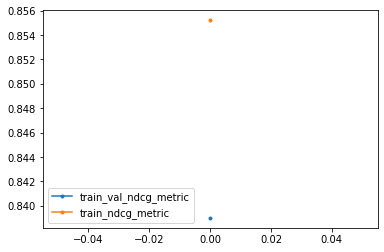

In [ ]:
import matplotlib.pyplot as plt

def get_data(data, key):
    return [x[0][key] for x in data]

plt.clf()
for prefix in ["train_val", "train"]:
    for key in [f"{prefix}_ndcg_metric"]:
        plt.plot(get_data(loop_stats, key), marker='.', label=key)

_ = plt.legend(loc="lower left", frameon=True)


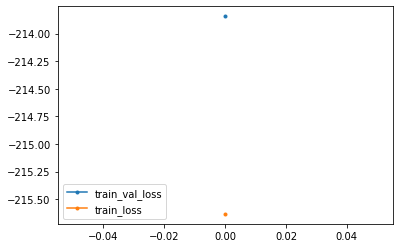

In [ ]:
plt.clf()
for prefix in ["train_val", "train"]:
    for key in [f"{prefix}_loss"]:
        plt.plot(get_data(loop_stats, key), marker='.', label=key)

_ = plt.legend(loc="lower left", frameon=True)

In [ ]:
stats = est.evaluate(
    sdf_list_padded_test,
    feature_cols=X_COLS,
    label_cols=[Y_COL],
    num_steps=1,
    verbose=False
)
print(stats)

2022-05-17 04:32:36,427	WARNING worker.py:1228 -- WARNING: 21 PYTHON worker processes have been started on node: 360d0c0b26cf63dd4aff97bdae6d417272c2a7d71a29ef35f157588b with address: 172.28.0.2. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
[Stage 518:>                                                        (0 + 1) / 1]2022-05-17 04:32:38,545	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
(Worker pid=134125) 2022-05-17 04:32:41.706172: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [ ]:
sdf_output = est.predict(
    sdf_list_padded_test,
    feature_cols=X_COLS,
    steps=1,
    verbose=False
)

[{'validation_ndcg_metric': 0.8397074937820435,
  'validation_root_mean_squared_error': 1574.648681640625}]

In [ ]:

sdf_output.printSchema()
sdf_output.show(10)

root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)
 |-- prediction: vector (nullable = true)

+------+--------------------+--------------------+---+--------------------+
|userid|              titles|             ratings|len|          prediction|
+------+--------------------+--------------------+---+--------------------+
|  4169|[Parent Trap, The...|[4, 4, 1, 5, 3, 4...|312|[10.0495653152465...|
|  1680|[GoldenEye (1995)...|[3, 3, 4, 4, 4, 4...|264|[10.7592430114746...|
|  4277|[Extreme Measures...|[4, 4, 4, 4, 5, 5...|249|[9.35473918914795...|
|  1181|[Shaggy Dog, The ...|[3, 3, 1, 3, 3, 3...|232|[10.0058364868164...|
|   889|[Shall We Dance? ...|[5, 4, 2, 3, 2, 4...|226|[11.8175363540649...|
|  1941|[Herbie Rides Aga...|[4, 5, 5, 4, 1, 4...|221|[10.2106609344482...|
|  1449|[Angels in the

In [ ]:
from pyspark.sql.functions import explode


def unpad_prediction(sdf):
    def unpad_list(lst, length):
        return lst[:length]

    unpad_str_udf = F.udf(lambda x, y: unpad_list(x, y), ArrayType(StringType(), True))
    unpad_int_udf = F.udf(lambda x, y: unpad_list(x, y), ArrayType(IntegerType(), True))
    unpad_pred_udf = F.udf(lambda x, y: unpad_list(x.toArray().tolist(), y), ArrayType(FloatType(), True))

    sdf_out = (
        sdf
        .withColumn("titles", unpad_str_udf(F.col("titles"), F.col("len")))
        .withColumn("ratings", unpad_int_udf(F.col("ratings"), F.col("len")))
        .withColumn("prediction", unpad_pred_udf(F.col("prediction"), F.col("len")))
    ).sort(F.asc("len"))

    return sdf_out


sdf_unpad = unpad_prediction(sdf_output)
sdf_unpad.printSchema()
sdf_unpad.show(10)
sdf_unlist = sdf_unpad.selectExpr('inline(arrays_zip(prediction, labels))')
sdf_unlist.show(20)

root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)
 |-- prediction: array (nullable = true)
 |    |-- element: float (containsNull = true)



+------+--------------------+-------+---+-----------+
|userid|              titles|ratings|len| prediction|
+------+--------------------+-------+---+-----------+
|  1510|[Legends of the F...|    [4]|  1| [9.297303]|
|  1259|[Return of the Fl...|    [4]|  1|[6.5021152]|
|  5863|[Stuart Little (1...|    [3]|  1| [8.567881]|
|  4988|[Dead Man Walking...|    [5]|  1| [7.544215]|
|  1936|[Sound of Music, ...|    [4]|  1|[5.5240088]|
|  1620| [Limey, The (1999)]|    [4]|  1| [8.162466]|
|  1282| [Roger & Me (1989)]|    [5]|  1|[7.1391716]|
|  3826|[Dead Man Walking...|    [4]|  1|[5.8432117]|
|  2930|[Color Purple, Th...|    [3]|  1|[7.5742407]|
|   747|[Saving Private R...|    [4]|  1|[10.410028]|
+------+--------------------+-------+---+-----------+
only showing top 10 rows



In [ ]:
est.save("./test_model.ckpt")


'./test_model.ckpt'

In [ ]:
est.shutdown()

In [ ]:
est = Estimator.from_keras(model_creator=create_model,  config=model_config, workers_per_node=1)

(Worker pid=37204) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(Worker pid=37204) Instructions for updating:
(Worker pid=37204) use distribute.MultiWorkerMirroredStrategy instead
(Worker pid=37204) 2022-03-03 06:51:48.445349: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
est.load("./test_model.ckpt")

In [ ]:
sdf_output = est.predict(
    sdf_list_padded_test,
    feature_cols=feature_cols,
    steps=1,
    verbose=False,
)

2022-03-03 06:52:11,990	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
[Stage 155:>                                                       (1 + 1) / 74]2022-03-03 06:52:12,587	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
[Stage 155:=>                                                      (2 + 1) / 74]2022-03-03 06:52:13,168	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
[Stage 155:==>                                                     (3 + 1) / 74]2022-03-03 06:52:13,764	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
[Stage 155:===>                                                    (4 + 1) / 74]2022-03-03 06:52:14,438	INFO worker.py:843 -- Connecting to existing Ray cluster at address: 172.28.0.2:6379
[Stage 155:===>                                                    (5 + 1) / 74]2022-03-03 06:52:15,070	INFO worker.py:843 -- Connectin

In [ ]:

sdf_unpad = unpad_prediction(sdf_output).sort(F.desc("len"))
sdf_unpad.printSchema()

root
 |-- userid: string (nullable = true)
 |-- titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ratings: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- len: integer (nullable = true)
 |-- prediction: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [ ]:
from pyspark.sql.functions import explode
sdf_tmp = sdf_unpad.select("userid", "titles", "ratings", "prediction")
sdf_tmp2 = sdf_tmp.selectExpr('userid', 'inline(arrays_zip(titles, ratings, prediction))')
sdf_tmp2.show(20)

[Stage 183:======================================================>(73 + 1) / 74]

+------+--------------------+-------+----------+
|userid|              titles|ratings|prediction|
+------+--------------------+-------+----------+
|  4169|Parent Trap, The ...|      4| 10.049565|
|  4169|Swiss Family Robi...|      4| 10.079399|
|  4169|    Mr. Wrong (1996)|      1|  7.965984|
|  4169| Mary Poppins (1964)|      5| 10.707472|
|  4169|Pete's Dragon (1977)|      3|  9.611323|
|  4169|Alice in Wonderla...|      4| 10.569653|
|  4169|To Gillian on Her...|      4|  8.966696|
|  4169|Get on the Bus (1...|      4| 10.361752|
|  4169|        Johns (1996)|      3|  9.911037|
|  4169|Dirty Dancing (1987)|      3|  9.834489|
|  4169|      Platoon (1986)|      5| 10.311012|
|  4169|Christmas Carol, ...|      4|10.2826185|
|  4169|Associate, The (1...|      4| 10.775612|
|  4169|   Glory Daze (1996)|      2| 9.7413225|
|  4169|Return of the Pin...|      3| 10.423382|
|  4169|   Abyss, The (1989)|      4| 10.351718|
|  4169| Howling, The (1980)|      4|  8.359009|
|  4169|     Raw Dea

In [ ]:
est.shutdown()

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()

Stopping orca context
